In [1]:
from pathlib import Path

import polars as pl
from atollgen_cli.runner import DataHolder
from entrez_fetcher.genome_store import GenomeStore
from matplotlib import pyplot as plt
from scibelt.aggregates import Dataset, aggregate_format, format_data
from scibelt.viz import (
    FigureSaver,
    get_legend_hl,
    propbarplot,
    alias_or_name,
    latex_size,
)
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np

In [2]:
data_holder = DataHolder(Path("../data/interim/"), ensure_data=False)
adb_path = data_holder.db_dir / "adb"
adb_sources_dir = data_holder.db_dir / "sources"
genome_store_dir = data_holder.db_dir / "genomes"
genome_store = GenomeStore(genome_store_dir)

ds = Dataset.from_folder(
    "../data/post-process/base_nooverlaps/", genome_store=genome_store
)

fs = FigureSaver("../figures/main/fig06/")

In [3]:
colors = {
    info.get("alias", name): info.get("color")
    for name, info in format_data["cargo_type"].items()
}

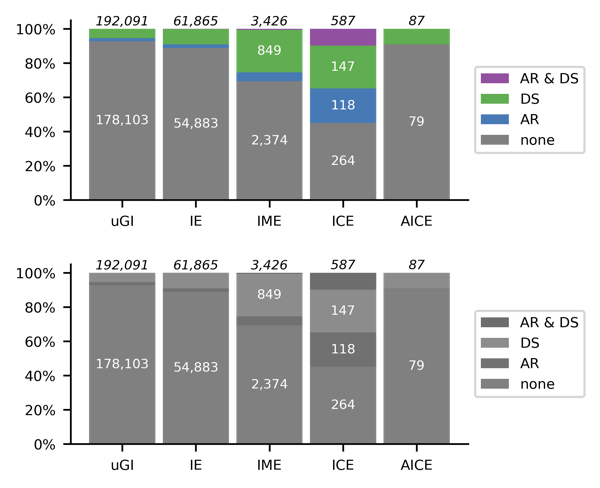

In [4]:
df = ds.cargo_by_label
df = aggregate_format(df, index="label", columns="cargo_type")
df = df.filter(pl.col("label") != "ψICE")
with latex_size(double=False, height=1.5):
    fig, ax = plt.subplots()
    propbarplot(
        df.to_pandas().set_index("label"),
        ax=ax,
        legend=False,
        kind="bar",
        color=colors,
    )
    ax.grid(False)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    ax.set_xlabel("")
    ax.legend(*get_legend_hl(ax), ncol=1, loc="center left", bbox_to_anchor=(1.0, 0.5))
fs.savefig(fig, "panel_A")

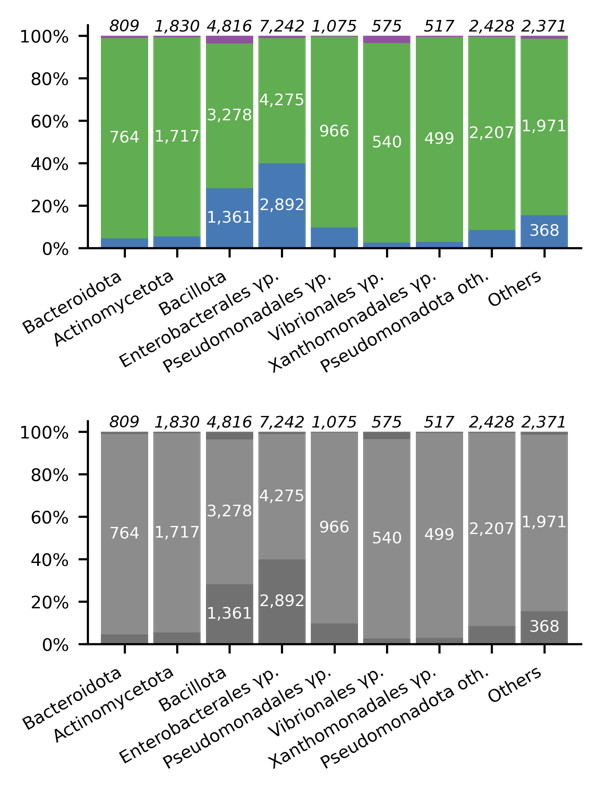

In [5]:
df = ds.cargo_by_phylum
df = aggregate_format(df, index="phylum", columns="cargo_type")
phyl8s = alias_or_name(format_data["phylum_8"])
in_phy8 = pl.col("phylum").is_in(phyl8s)
df = pl.concat(
    [
        df.filter(in_phy8),
        df.filter(~in_phy8).sum().with_columns(phylum=pl.lit("Others")),
    ]
)
with latex_size(double=False, height=1.5):
    fig, ax = plt.subplots()
    propbarplot(
        df.drop("none").to_pandas().set_index("phylum").loc[phyl8s],
        ax=ax,
        legend=False,
        kind="bar",
        color=colors,
    )
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.grid(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    ax.set_xlabel("")
fs.savefig(fig, "panel_B")